In [1]:
import pandas as pd
import numpy as np
import scipy
import scipy.stats
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.optimizers import Adam
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import hyperopt.fmin as hypfmin
import keras
import theano
import random
import os
import pickle

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Using Theano backend.


In [2]:
keras.__version__

'1.2.2'

In [3]:
theano.__version__

'0.9.0'

## Set plotting style

In [4]:
plt.rcParams["patch.force_edgecolor"] = True
sns.set_style('whitegrid',
              {'axes.grid': True,
               'grid.linestyle': u'--',
               'axes.edgecolor': '0.1',
               'axes.labelcolor': '0',
               'axes.labelsize': 15,
               'axes.titlesize': 15,
               'legend.fontsize': 15,
               'xtick.labelsize': 15,
               'ytick.labelsize': 15,
               })

## Check if the various directories that you might care about in the future are present

In [ ]:
data_dir = '../Data/'
results_dir = '../Results/'
figures_dir = '../Figures/'

if not os.path.exists(data_dir):
    os.mkdir(data_dir)
    
if not os.path.exists(results_dir):
    os.mkdir(results_dir)
    
if not os.path.exists(figures_dir):
    os.mkdir(figures_dir)

## Create a directory to save the model parameters:

In [5]:
model_name = 'Random_UTR_CNN'
model_params_dir = '../Results/{0}.Hyperparam.Opt/'.format(model_name)

if not os.path.exists(model_params_dir):
    os.mkdir(model_params_dir)

## Load our cleaned up data.

The csv should be tab-separated. The read counts are log2.

In [6]:
data = pd.read_csv(data_dir + 'Random_UTRs.csv')

## One-hot encoding of the sequences.

i.e. we're converting the sequences from being represented as a 50 character string of bases to a 4x50 matrix of 1's and 0's, with each row corresponding to a base and every column a position in the UTR.

In [7]:
# one hot encoding of UTRs
# X = one hot encoding matrix
# Y = growth rates

def one_hot_encoding(df, seq_column, expression):
    
    bases = ['A','C','G','T']
    base_dict = dict(zip(bases,range(4))) # {'A' : 0, 'C' : 1, 'G' : 2, 'T' : 3}

    n = len(df)
    
    # length of the UTR sequence
    # we also add 10 empty spaces to either side
    total_width = df[seq_column].str.len().max() + 20
    
    # initialize an empty numpy ndarray of the appropriate size
    X = np.zeros((n, 1, 4, total_width))
    
    # an array with the sequences that we will one-hot encode
    seqs = df[seq_column].values
    
    # loop through the array of sequences to create an array that keras will actually read
    for i in range(n):
        seq = seqs[i]
        
        # loop through each individual sequence, from the 5' to 3' end
        for b in range(len(seq)):
            # this will assign a 1 to the appropriate base and position for this UTR sequence
            X[i, 0, base_dict[seq[b]], int(b + round((total_width - len(seq))/2.))] = 1.
    
        # keep track of where we are
        if (i%10000)==0:
            print i,
        
    X = X.astype(theano.config.floatX)
    Y = np.asarray(df[expression].values,
                   dtype = theano.config.floatX)[:, np.newaxis]
    
    return X, Y, total_width

In [8]:
X, Y, total_width = one_hot_encoding(data, 'UTR', 'growth_rate')

0 10000 20000 30000 40000 50000 60000 70000 80000 90000 100000 110000 120000 130000 140000 150000 160000 170000 180000 190000 200000 210000 220000 230000 240000 250000 260000 270000 280000 290000 300000 310000 320000 330000 340000 350000 360000 370000 380000 390000 400000 410000 420000 430000 440000 450000 460000 470000 480000


## Split the data into test and training sets

If we have more reads for a given UTR at the outset, we can be more confident that we have made an accurate measurement. For this reason, we use those UTRs with the most reads to test our model on, because these should have the least experimental noise. We hold out the UTRs that fall in top 5% of reads at the first time point as our test set.

In [9]:
# a sorted numpy array of UTR indexes, from least reads to most reads
sorted_inds = data.sort_values('t0').index.values


train_inds = sorted_inds[:int(0.95*len(sorted_inds))] # 95% of the data as the training set


test_inds = sorted_inds[int(0.95*len(sorted_inds)):] # UTRs with most reads at time point 0 as the test set

# set the seed before randomly shuffling the data
seed = 0.5
random.shuffle(train_inds, lambda :seed)

## Hyperparameter search

Before training the model, we perform a hyperparameter search to narrow down which model architecture to use. Of course, we do a fair amount of narrowing ourselves by selecting which architectures are available for the search.

The dictionary 'hyperparams' has the same values as the 'space' object, 'space' is just the form that's compatible with hyperopt.

In [ ]:
hyperparams = {'conv_width' : [9, 13, 17, 25],
               'conv_filters' : [32, 64, 128, 256],
               'conv_layers' : [2, 3, 4],
               'dense_layers' : [1, 2],
               'conv_dropout' : [None, 0.15],
               'dense_dropout' : [None, 0.1, 0.25, 0.5],
               'dense_units' : [32, 64, 128, 256]}

In [ ]:
space = {   'conv_width': hp.choice('conv_width', [9, 13, 17, 25]),
            'conv_filters': hp.choice('conv_filters', [32, 64, 128, 256]),
            'conv_layers': hp.choice('conv_layers', [2, 3, 4]),
            'dense_layers': hp.choice('dense_layers', [1, 2]),
            'conv_dropout': hp.choice('conv_dropout',  [None, 0.15]),
            'dense_dropout': hp.choice('dense_dropout', [None, 0.1, 0.25, 0.5]),
            'dense_units': hp.choice('dense_units', [32, 64, 128, 256]),
        }

#### Defining a function to build the model

- Note: we reuse this same function lower down after we've decide on a model architecture 

In [ ]:
def create_model(params):
    model = Sequential()
    model.add(Convolution2D(params['conv_filters'],
                            4,
                            params['conv_width'],
                            border_mode = 'valid',
                            input_shape = (1, 4, total_width),
                            activation = 'relu'))
    
    # add dropout at the convolutional layers if appropriate
    if params['conv_dropout']:
        model.add(Dropout(p = params['conv_dropout']))
    
    # add the appropriate number of additional convolutional layers, along with dropout
    for i in range(params['conv_layers'] - 1):
        model.add(Convolution2D(params['conv_filters'],
                                1,
                                params['conv_width'],
                                border_mode = 'same',
                                activation = 'relu'))
        
        if params['conv_dropout']:
            model.add(Dropout(params['conv_dropout']))
    
    model.add(Flatten())
    
    # add the appropriate number of dense layers and dropout
    for i in range(params['dense_layers']):
        model.add(Dense(output_dim = params['dense_units'],
                        activation = 'relu'))
        
        if params['dense_dropout']:
            model.add(Dropout(p = params['dense_dropout']))
    
    # add the output layer, since we want to predict the "growth rate" we only want a single 
    # number, hence the single dimension
    model.add(Dense(output_dim = 1))
    
    # compile the model
    model.compile(loss = 'mean_squared_error',
                  optimizer = 'adam',
                  metrics = ['mean_squared_error'])
    
    return model

#### We also need a function that builds and fits the model, which we can pass to the hyperparameter search.

- It also returns some information regarding overfitting, etc.
- note that the data is included inside the function, I'm not passing it to the function.

In [ ]:
def f_nn(params):
    
    model = create_model(params)
    
    # track model overfitting
    earlyStopping = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                  patience = 1,
                                                  verbose = 0,
                                                  mode = 'auto')
    history = keras.callbacks.History()
    
    # keep track of where we are while the code in this cell is running
    global n
    print "\n", n
    n+=1
    print params
    
    # fit the model
    # note that I'm not passing the data to this function, I've just included it here (i.e. I've
    # included X and Y)
    model.fit(X[train_inds],
              Y[train_inds],
              validation_split = 0.2,
              callbacks = [earlyStopping, history],
              verbose = 0,
              nb_epoch = 100)
    
    print 'MSE:',earlyStopping.best
    return {'loss': earlyStopping.best, 'status': STATUS_OK}

#### Actually perform the hyperparameter search.

A note here, there're random elements in keras and hypfmin that I don't understand how to control, so I haven't been able to set a seed that will allow you to obtain exactly the same results for the hyperparameter search that we have.

In [ ]:
n = 0

trials = Trials()
best = hypfmin(f_nn, space,
               algo = tpe.suggest,
               max_evals = 50,
               trials = trials)
print 'best: '
print best

pickle the model

In [ ]:
with open(model_params_dir + 'hyperparam_test.pkl', 'w') as f:
    pickle.dump(trials.trials, f)

and take a look a the winning architecture

In [ ]:
opt_params = {}

for p in best:
    opt_params[p] = hyperparams[p][best[p]]

In [ ]:
opt_params

## Create and train the convolutional neural network

In [ ]:
model = create_model(opt_params)

In [ ]:
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience = 0,
                                              verbose = 0,
                                              mode = 'auto')

history = keras.callbacks.History()

modelcheckpoint = keras.callbacks.ModelCheckpoint(model_params_dir + 'model_weights.hdf5',
                                                  monitor = 'val_loss',
                                                  verbose = 0,
                                                  save_best_only = True,
                                                  mode = 'auto')

In [ ]:
model.fit(X[train_inds],
          Y[train_inds],
          validation_split = 0.1,
          callbacks = [earlyStopping,
                       history,
                       modelcheckpoint],
          verbose=1,
          nb_epoch = 100)

#### Save the model

In [ ]:
json_string = model.to_json()
open(model_params_dir + 'model_arch.json', 'w').write(json_string)
model.save_weights(model_params_dir + 'model_weights.h5')

## Use the model to predict the growth rates from our library of 5' UTR sequences

- we do this on the entire library because we want to compare the fits of the test and training data.
    - you would generally expect to maybe do a little better on the training data. However, since we use the highest quality data for our test set -- the values that we're most confident about -- it's not maybe not that surprising that our predictions are more accurate on our test set (see results two cells down).

In [ ]:
Y_pred = model.predict(X,verbose=1)

In [ ]:
# R^2 value for our predictions on the training set
print scipy.stats.pearsonr(Y[train_inds].flatten(),
                           Y_pred[train_inds].flatten())[0]**2

# and on the test set
print scipy.stats.pearsonr(Y[test_inds].flatten(),
                           Y_pred[test_inds].flatten())[0]**2

## Make sure the model architecture and parameters are saved correctly

In [10]:
!ls {model_params_dir}

hyperparam_test.pkl        model_weights.h5
hyperparam_test_binary.pkl model_weights.hdf5
model_arch.json


In [11]:
model = keras.models.model_from_json(open(model_params_dir + 'model_arch.json').read())
model.load_weights(model_params_dir + 'model_weights.hdf5')
model.compile(loss='mean_squared_error', optimizer='adam')

In [12]:
Y_pred = model.predict(X, verbose=1)

489344/489348 [============================>.] - ETA: 0s

In [13]:
# R^2 value for our predictions on the training set
print scipy.stats.pearsonr(Y[train_inds].flatten(),
                           Y_pred[train_inds].flatten())[0]**2

# and on the test set
print scipy.stats.pearsonr(Y[test_inds].flatten(),
                           Y_pred[test_inds].flatten())[0]**2

0.491536183855
0.62330394125


## Plot results

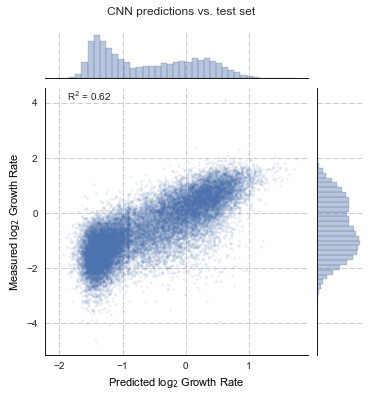

In [14]:
# data
x = Y_pred[test_inds].flatten()
y = Y[test_inds].flatten()

# calculate R^2
r2 = scipy.stats.pearsonr(x, y)[0]**2


g = sns.jointplot(x,
                  y,
                  stat_func = None,
                  kind = 'scatter',
                  s = 5,
                  alpha = 0.1,
                  size = 5)

g.ax_joint.set_xlabel('Predicted log$_2$ Growth Rate')
g.ax_joint.set_ylabel('Measured log$_2$ Growth Rate')


text = "R$^2$ = {:0.2}".format(r2)
plt.annotate(text, xy=(-5.5, 0.95), xycoords='axes fraction')

plt.title("CNN predictions vs. test set", x = -3, y = 1.25)

## Save data and predictions to csv

In [ ]:
data['pred_growth_rate'] = Y_pred

In [ ]:
data.to_csv(data_dir + 'Random_UTRs_with_predictions.csv')